# Multi Label Classification

In [1]:
import os, csv
from time import gmtime, strftime
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import random, math
import tensorflow as tf
import configs.config as cfg
import networks.mobilenet_V2 as model
import data.datapipe as datasets
import scipy.misc as sm

/home/dp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load class labels and Image files

In [2]:
base_dir = 'data/images'
filenames = sorted(os.listdir(base_dir))

classes=[]
with open('data/train_class_names.csv', 'r', newline='') as f:
    lines = csv.reader(f)
    for i in lines:
        id = i[0]
        c_name = i[-1]
        classes.append(c_name)
    f.close()

images_list = []
for i in range(len(filenames)):
    img = sm.imread(base_dir+'/'+filenames[i], mode='RGB')
    images_list.append(img)


# build Graph for ML Classification

In [3]:
# Create global_step
with tf.device('/cpu:0'):
    inputs = tf.placeholder(dtype=tf.float32, shape=(None, None, 3), name='input')
    processing_X = datasets._preprocess_for_test(inputs)
    processing_X = tf.expand_dims(processing_X, 0)
    print(processing_X.shape)

with tf.device('/cpu:0'):
    nets = model.MobileNet_V2(processing_X,
                              num_classes=cfg.FLAGS.num_classes,
                              is_training=False,
                              weight_decay=cfg.FLAGS.weight_decay)

    probs = nets.end_points['probs']
    probs = tf.cast(probs, tf.float32)
    print(probs)

    """ create saver and initialize variables """
    saver = tf.train.Saver()
    init_op = tf.group(tf.global_variables_initializer(),
                       tf.local_variables_initializer())
    model_path = 'output/models/MB_V2_ML_Recognition_final.ckpt'
    print('model_path : ', model_path)


(1, 299, 299, 3)
Tensor("ExpandDims_1:0", shape=(1, 299, 299, 3), dtype=float32, device=/device:CPU:0)
Tensor("Predictions:0", shape=(1, 19305), dtype=float32, device=/device:CPU:0)
Tensor("Predictions:0", shape=(1, 19305), dtype=float32, device=/device:CPU:0)
model_path :  output/models/MB_V2_ML_Recognition_final.ckpt


# Run Model

In [4]:
predictions = []    
with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as sess:
    sess.run(init_op)
    saver.restore(sess, model_path)
    print ('Evaluating...')
    for i in range(len(images_list)):
        im = images_list[i]
        preds = sess.run(probs[0], feed_dict={inputs: im})
        predictions.append(preds)
    sess.close()


INFO:tensorflow:Restoring parameters from output/models/MB_V2_ML_Recognition_final.ckpt
Evaluating...


# visualize the results

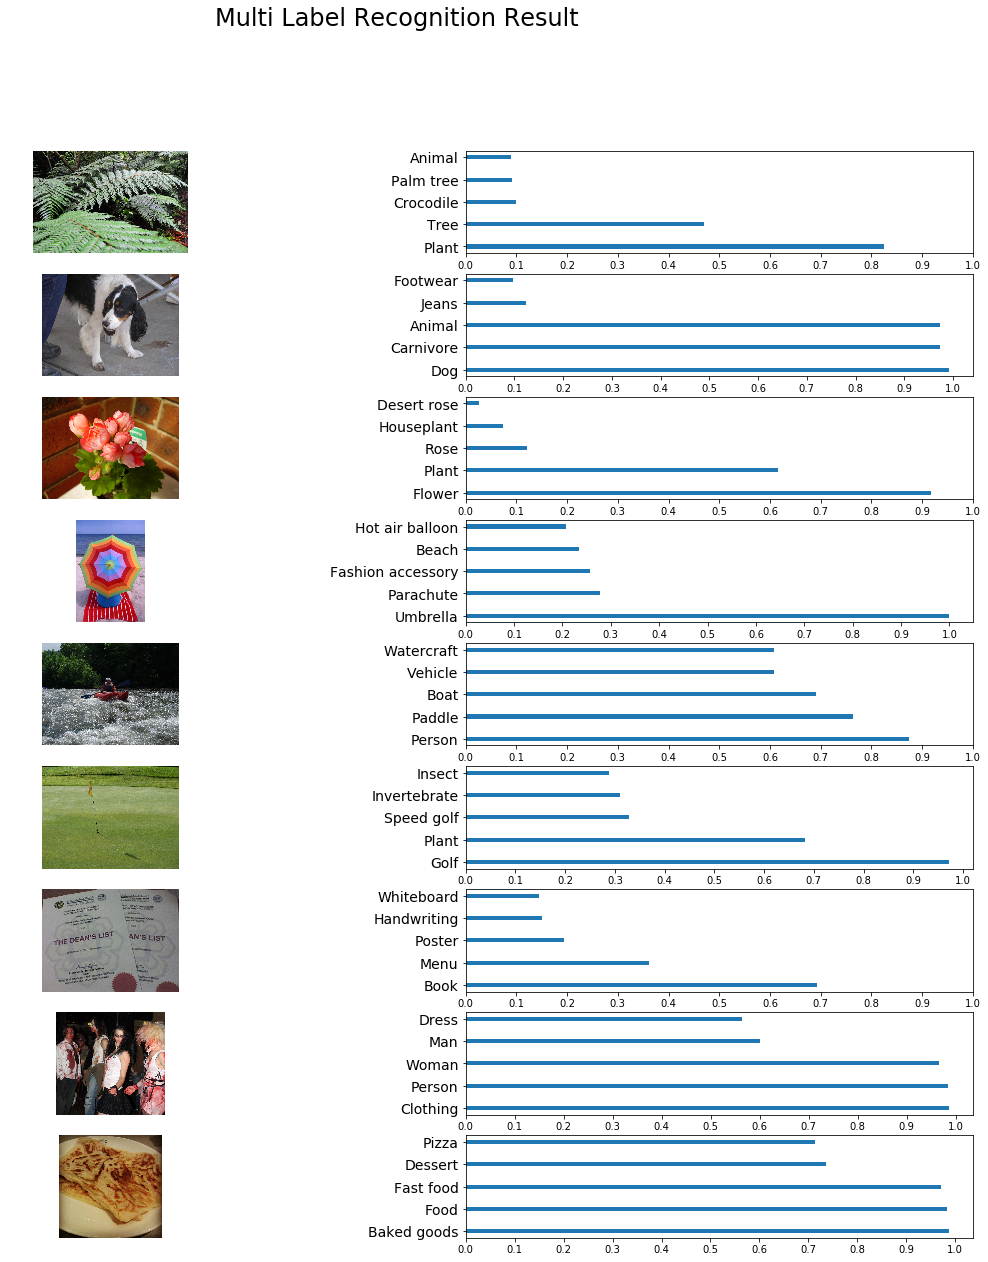

In [5]:
fig, axes = plt.subplots(nrows=len(images_list), ncols=2, figsize=(20, 20))
# fig.tight_layout()
fig.suptitle("Multi Label Recognition Result", fontsize=24)

max_preds = 5
margin = 0.05
width = (1. - 2*margin) / max_preds
x_labels = np.linspace(0, 1, 11)

for row in range(len(images_list)):
    im = images_list[row]
    pred = predictions[row]
    class_ids = np.argpartition(pred, -max_preds)[-max_preds:]
    scores = pred[class_ids]
    arg_inds = np.argsort(scores)[::-1]
    class_name = [classes[idx] for idx in class_ids[arg_inds]]

    axes[row][0].imshow(im)
    axes[row][0].set_axis_off()
    
    axes[row][1].barh(np.arange(max_preds)+margin, scores[arg_inds], width)
    axes[row][1].set_yticks(np.arange(max_preds)+margin)
    axes[row][1].set_yticklabels(class_name, fontsize=14)
    axes[row][1].set_xticks(x_labels)
plt.show()
    